## Librerias

In [1]:
!pip install tensorflow-text
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [2]:
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import os
import pickle
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
RUTA = "/content/drive/MyDrive/NLP"

In [5]:
path_csv = "/content/drive/MyDrive/NLP/reviews_large_processed.csv"
df = pd.read_csv(path_csv, sep=';', decimal='.')

In [6]:
df.head()

,overall,reviewText
0,2,My son loves wii and wii U.He does not like th...
1,1,Waste of money on a dead game. No one plays th...
2,4,Plugging the red and white audio jacks intoyou...
3,4,I purchased this for my husband since he neede...
4,2,"It's difficult to control the cars, and the ma..."


- Dividimos un conjunto de datos de reseñas en subconjuntos para entrenamiento, validación y prueba.
- Utilizamos `train_test_split` para:
  - Separaramos las características (`reviewText`) y las etiquetas (`overall`).
  - Asignamos el 10% del conjunto a entrenamiento y otro 10% a prueba inicialmente.
  - Mezclamos los datos (`shuffle=True`) para asegurar una distribución aleatoria.
  - Mantener proporciones de clases (`stratify`) entre los conjuntos.
  - Fijamos una semilla para reproducibilidad (`random_state=42`).
- Realizamos una segunda división del conjunto de prueba inicial para obtener conjuntos iguales de validación y prueba finales.



In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'].to_numpy(),
                                                    df['overall'].to_numpy(),
                                                    train_size=0.1,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    stratify=df['overall'],
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                shuffle=True,
                                                stratify=y_test,
                                                random_state=42)

print(f'Dimensiones del dataset de training:   {X_train.shape}')
print(f'Dimensiones del dataset de validation: {X_val.shape}')
print(f'Dimensiones del dataset de test:       {X_test.shape}')


Dimensiones del dataset de training:   (1827,)
Dimensiones del dataset de validation: (914,)
Dimensiones del dataset de test:       (914,)


### Funciones auxiliares

- Recuperamos datos preprocesados desde un objeto de caché para los conjuntos de entrenamiento, validación y prueba, tanto para las características (textos de reseñas) como para las etiquetas (calificaciones).
- Asignamos estos datos a variables correspondientes para su uso posterior en el flujo de trabajo de NLP, facilitando el acceso directo a los conjuntos de datos ya preparados sin necesidad de repetir el preprocesamiento.


In [10]:
def preprocess_data(data_train, data_val , data_test, labels_train, labels_val, labels_test,
                    cache_dir=os.path.join("cache", "sentiment_analysis"), cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    cache_data = None
    if cache_file is not None:
      try:
        with open(os.path.join(cache_dir, cache_file), "rb") as f:
            cache_data = pickle.load(f)
        print("Read preprocessed data from cache file:", cache_file)
      except:
        pass

    if cache_data is None:
          words_train = list(map(review_to_words, data_train))
          words_val   = list(map(review_to_words, data_val))
          words_test  = list(map(review_to_words, data_test))

          if cache_file is not None:
            cache_data = dict(words_train=words_train, words_val=words_val, words_test=words_test,
                                    labels_train=labels_train , labels_val =labels_val , labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
              pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
      words_train, words_val, words_test, labels_train, labels_val, labels_test = (cache_data['words_train'],
                                                                                        cache_data['words_val'],
                                                                                        cache_data['words_test'],
                                                                                        cache_data['labels_train'],
                                                                                        cache_data['labels_val'],
                                                                                        cache_data['labels_test'])
    return words_train, words_val, words_test, labels_train,labels_val, labels_test

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib


- **Función `review_to_words`**: Convierte una cadena de texto de una reseña en una secuencia de palabras preprocesadas.
  - **Eliminación de etiquetas HTML**: Utiliza `BeautifulSoup` para quitar etiquetas HTML del texto, dejando solo el contenido visible.
  - **Normalización de texto**: Convierte el texto a minúsculas y elimina todo lo que no sea texto alfanumérico (letras y números).
  - **Tokenización**: Divide el texto en palabras individuales (tokens) basándose en espacios.
  - **Filtrado de stopwords**: Remueve palabras comunes en inglés (`stopwords`) que suelen ser irrelevantes para el análisis.
  - **Filtrado alfabético**: Elimina tokens que no sean estrictamente alfabéticos, descartando números y símbolos restantes.
  - **Stemming**: Reduce las palabras a su raíz o forma base utilizando el `PorterStemmer`, para consolidar variantes de una misma palabra.

Este proceso prepara el texto de las reseñas para análisis de NLP, facilitando tareas como la clasificación de sentimientos al estandarizar y simplificar el input de texto.


In [9]:

def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    # Eliminamos las etiquetas HTML
    #text = re.sub( re.compile('<.*?>'), '', review)
    text = BeautifulSoup(review, "html5lib").get_text()
    # Convertimos a minúscula y quitamos todo lo que no sea texto o números
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # Dividimos en tokens por espacios
    words = text.split()
    # Eliminamos stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    words = [w for w in words if w.isalpha()]
    # Aplicamos stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words

- **Preparación para la función de limpieza de texto**:
  - **BeautifulSoup**: Importado para eliminar etiquetas HTML de las reseñas, asegurando que solo se procese el texto visible.
  - **RegEx (`re`)**: Utilizado para eliminar caracteres que no sean letras, permitiendo una limpieza más profunda del texto.
  - **NLTK**:
    - Se descargan las `stopwords` para filtrar palabras comunes en inglés que aportan poco valor al análisis.
    - **PorterStemmer**: Importado para aplicar stemming a las palabras, reduciéndolas a su raíz y estandarizando variantes de una misma palabra.
  
Estas herramientas y librerías preparan el ambiente para el preprocesamiento efectivo del texto, esencial para las siguientes etapas de análisis en tareas de NLP.


In [8]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- **Configuración del directorio de caché**:
  - Crea un directorio llamado `cache/sentiment_analysis` si no existe, para almacenar datos preprocesados y facilitar el acceso rápido en futuras ejecuciones.

- **Preprocesamiento de los datos**:
  - Ejecuta la función `preprocess_data` sobre los conjuntos de entrenamiento, validación y prueba, tanto para las características (textos de las reseñas) como para las etiquetas (calificaciones de sentimiento).
  - Esta función aplica limpieza y normalización al texto, convierte las reseñas en una secuencia de palabras preprocesadas y verifica si los datos ya están disponibles en caché para evitar re-procesamientos innecesarios.
  - Almacena los resultados del preprocesamiento (palabras y etiquetas para entrenamiento, validación y prueba) en variables correspondientes para su uso en etapas de modelado y evaluación.


In [11]:
cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)
words_train , words_val, words_test, labels_train ,labels_val , labels_test = preprocess_data(X_train, X_val , X_test , y_train, y_val, y_test)

<ipython-input-9-c0251b1a7034>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(review, "html5lib").get_text()


Wrote preprocessed data to cache file: preprocessed_data.pkl


- **Extracción de características Bag-of-Words (BoW)**:
  - La función `extract_BoW_features` transforma documentos preprocesados en vectores BoW, utilizando un tamaño de vocabulario máximo y almacenando el resultado en caché para uso futuro.
  - Intenta leer características BoW desde un archivo de caché para evitar re-cálculos.
  - Si no hay datos en caché, usa `CountVectorizer` para convertir secuencias de palabras a vectores BoW con un límite en el tamaño del vocabulario y una frecuencia mínima de documento.
  - Las características de entrenamiento, validación y prueba se convierten en matrices numéricas y se guardan en caché si es necesario.
  - Devuelve matrices de características BoW para conjuntos de entrenamiento, validación y prueba, junto con el vocabulario utilizado.

- **Evaluación del Modelo**:
  - `calculate_results` calcula y devuelve precisión, recall, y puntuación F1 de un modelo de clasificación binaria, usando etiquetas verdaderas y predicciones.
  - Utiliza la función `accuracy_score` para calcular la precisión del modelo y `precision_recall_fscore_support` para calcular precision, recall y F1 con un promedio ponderado.
  - Devuelve un diccionario con las métricas de rendimiento del modelo.


In [12]:
def extract_BoW_features(words_train, words_val , words_test, vocabulary_size=500,
                         cache_dir=os.path.join("cache", "sentiment_analysis"), cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass

    if cache_data is None:
        vectorizer = CountVectorizer(max_features=vocabulary_size,min_df=0.0175, preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        features_val = vectorizer.transform(words_val).toarray()
        features_test = vectorizer.transform(words_test).toarray()

        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_val=features_val, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        features_train, features_val, features_test, vocabulary = (cache_data['features_train'],
                 cache_data['features_val'] , cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_val, features_test, vocabulary

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

- Ejecutamos la función `extract_BoW_features` en los conjuntos de palabras preprocesadas para entrenamiento, validación y prueba.
- Obtiene matrices de características Bag-of-Words (BoW) y el vocabulario utilizado para cada conjunto de datos.
- Las variables `features_train`, `features_val`, `features_test` almacenan las matrices de características BoW resultantes.
- La variable `vocabulary` contiene el vocabulario generado por el vectorizador BoW.


In [13]:
features_train, features_val, features_test, vocabulary = extract_BoW_features(words_train,words_val, words_test)

Wrote features to cache file: bow_features.pkl


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vemos el vocabulario vectorizado BoW

In [14]:
len(vocabulary)

279

- **Función `plot_loss_curves`**:
  - Dibuja curvas de pérdida y precisión para los conjuntos de entrenamiento y validación, basándose en el historial de entrenamiento de un modelo de TensorFlow.
  - **Argumento `history`**: Objeto de historial de TensorFlow que contiene métricas de rendimiento a lo largo de las épocas de entrenamiento.
  - Extrae las métricas `loss` (pérdida de entrenamiento) y `val_loss` (pérdida de validación), así como `accuracy` (precisión de entrenamiento) y `val_accuracy` (precisión de validación) del historial.
  - Calcula el rango de épocas basado en la longitud del historial de pérdidas para el eje X.

- **Visualización**:
  - Primera gráfica: Muestra la pérdida (`loss` y `val_loss`) a lo largo de las épocas de entrenamiento.
  - Segunda gráfica: Presenta la precisión (`accuracy` y `val_accuracy`) a lo largo de las épocas de entrenamiento.
  - Cada gráfica incluye leyendas para distinguir entre los datos de entrenamiento y validación.

Esta función es útil para evaluar el rendimiento del modelo a lo largo del tiempo, identificando posiblemente sobreajuste (si la pérdida de validación aumenta con el tiempo) o subajuste (si ambas pérdidas permanecen altas), y ajustando la estrategia de entrenamiento según sea necesario.


In [31]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

#Carga de datos

- Sacamos el tamaño del vocabulario extraído durante la creación de las características Bag-of-Words (BoW), indicando la cantidad total de palabras únicas identificadas.
- Muestramos una muestra aleatoria de 8 palabras del vocabulario para dar una idea de los tipos de términos que incluye.
- Ejemplos de preprocesamiento y representación de características:
  - Muestra las palabras preprocesadas de la quinta reseña en el conjunto de entrenamiento, ilustrando cómo se ve el texto después del preprocesamiento.
  - Visualiza las características BoW correspondientes a la misma reseña, mostrando cómo se representa numéricamente el texto preprocesado.
  - Presenta la etiqueta (calificación de sentimiento) asociada con la quinta reseña en el conjunto de entrenamiento.


In [15]:
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Vocabulary: 279 words
Sample words: ['well', 'better', 'system', 'someth', 'beat', 'releas', 'sure', 'valu']

--- Preprocessed words ---
['someon', 'new', 'call', 'duti', 'game', 'learn', 'play', 'gameplay', 'smoothli', 'game', 'impress', 'whole', 'game', 'like', 'crysi', 'halo', 'compar', 'sinc', 'play', 'other', 'realli', 'like', 'game', 'great', 'campaign', 'spec', 'op', 'fun', 'never', 'play', 'zombi', 'compar', 'though', 'multiplay', 'well', 'similar', 'game', 'one', 'better', 'other']

--- Bag-of-Words features ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 5 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 


Sacamos la evaluación visual del resultado del preprocesamiento y la extracción de características en unas instancias específicas, ofreciendo una visión clara de cómo los datos originales se transforman para el modelado.


In [17]:
Index = 20
print("\n--- Preprocessed words ---")
print(words_train[Index])
print(len(words_train[Index]))
print("\n--- Bag-of-Words features ---")
print(features_train[Index])
print(len(features_train[Index]))
print("\n--- Label ---")
print(labels_train[Index])


--- Preprocessed words ---
['plug', 'overrid', 'hdmi', 'signal', 'altogeth', 'end', 'go', 'best', 'buy', 'purchas', 'turtl', 'beach', 'audio', 'adapt', 'work', 'perfectli']
16

--- Bag-of-Words features ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
279

--- Label ---
1


In [18]:
Index = 50
print("\n--- Preprocessed words ---")
print(words_test[Index])
print(len(words_test[Index]))
print("\n--- Bag-of-Words features ---")
print(features_test[Index])
print(len(features_test[Index]))
print("\n--- Label ---")
print(labels_test[Index])


--- Preprocessed words ---
['play', 'one', 'time', 'got', 'bore', 'realli', 'better', 'game', 'kid', 'realli', 'get', 'game', 'one']
13

--- Bag-of-Words features ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
279

--- Label ---
2


## Preparación datos entrenamiento

In [19]:
import sklearn.preprocessing as pr
from tensorflow.keras.utils import pad_sequences

- Establecemos el número máximo de palabras (`max_words`) para las secuencias en 200. Esto define la longitud uniforme que tendrán todas las secuencias de características después del padding.
- Aplicamos `pad_sequences` a las matrices de características BoW para entrenamiento (`features_train`), validación (`features_val`), y prueba (`features_test`):
  - **`maxlen=max_words`**: Aseguramos que todas las secuencias tengan una longitud fija de 200 palabras. Si una secuencia es más corta, se añadirán ceros al final hasta alcanzar la longitud deseada; si es más larga, se truncará.
  - **`padding='post'`**: Indica que el padding (relleno de ceros) se debe agregar al final de las secuencias si son más cortas que `max_words`.
- Los resultados son almacenados en `X_train_features`, `X_valid_features`, y `X_test_features`, preparando las secuencias para ser usadas directamente por modelos de deep learning que requieren una longitud de entrada fija.


In [20]:
max_words =200

X_train_features = pad_sequences(features_train, maxlen=max_words,padding='post')
X_valid_features = pad_sequences(features_val, maxlen=max_words,padding='post')
X_test_features  = pad_sequences(features_test, maxlen=max_words,padding='post')

In [21]:
X_train_features = pr.normalize(X_train_features, axis=1)
X_test_features = pr.normalize(X_test_features, axis=1)
X_valid_features = pr.normalize(X_valid_features, axis=1)

In [22]:
labels_train_bin = np.where(y_train<=3,0,1)
labels_val_bin   = np.where(y_val<=3,0,1)
labels_test_bin  = np.where(y_test<=3,0,1)

- Utilizamos `tf.data.AUTOTUNE` para optimizar automáticamente el rendimiento de carga de datos.
- Crea conjuntos de datos de TensorFlow (`tf.data.Dataset`) para entrenamiento, validación y prueba:
  - **`from_tensor_slices`**: Crea un dataset de TensorFlow a partir de las secuencias de características (BoW con padding) y las etiquetas binarizadas correspondientes a cada conjunto (entrenamiento, validación, prueba).
  - **`batch(batch_size=batch_size)`**: Organiza los datos en lotes de tamaño 128, lo cual es importante para el entrenamiento eficiente de modelos de deep learning, permitiendo la computación paralela y la actualización de pesos de manera más eficiente.
  - **`cache()`**: Almacena los datos en caché para que, durante la siguiente época del entrenamiento, la carga sea más rápida al evitar operaciones redundantes de lectura y preprocesamiento de los datos.
  - **`prefetch(buffer_size=AUTOTUNE)`**: Prepara datos para ser consumidos, cargando anticipadamente los lotes necesarios para la siguiente iteración de entrenamiento mientras el modelo está siendo entrenado en el l


In [23]:
import tensorflow as tf
batch_size = 128
AUTOTUNE   = tf.data.AUTOTUNE
train_data = tf.data.Dataset.from_tensor_slices((X_train_features,labels_train_bin)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
valid_data = tf.data.Dataset.from_tensor_slices((X_valid_features,labels_val_bin)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_data  = tf.data.Dataset.from_tensor_slices((X_test_features ,labels_test_bin)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

- Iteramos sobre los primeros dos lotes del conjunto de datos de entrenamiento (`train_data`) utilizando un bucle `for`.
- Para cada lote, imprime las secuencias de características de texto (`text`) y las etiquetas correspondientes (`label`).
  - **`text`**: Muestra las secuencias de características de texto (BoW con padding) para las reseñas en ese lote.
  - **`label`**: Muestra las etiquetas binarizadas (por ejemplo, sentimientos positivos o negativos) asociadas con cada secuencia de texto en el lote.
- El método `take(2)` limita la iteración a los primeros dos lotes del conjunto de datos de entrenamiento, permitiendo una inspección manual rápida del formato y contenido de los datos que se alimentarán al modelo durante el entrenamiento.


In [24]:
for text,label in train_data.take(2):
  print(text)
  print(label)

tf.Tensor(
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.37796447 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.47434165 0.         0.        ]], shape=(128, 200), dtype=float64)
tf.Tensor(
[1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0], shape=(128,), dtype=int64)
tf.Tensor(
[[0.         0.         0.         ... 0.5        0.         0.        ]
 [0.30151134 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.  

In [25]:
for text,label in test_data.take(2):
  print(text)
  print(label)

tf.Tensor(
[[0.         0.         0.         ... 0.37139068 0.         0.        ]
 [0.         0.         0.         ... 0.37796447 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.19611614 0.         0.         ... 0.         0.         0.        ]], shape=(128, 200), dtype=float64)
tf.Tensor(
[0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1
 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1], shape=(128,), dtype=int64)
tf.Tensor(
[[0.         0.         0.         ... 0.         0.21320072 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.  

# Entrenamiento / test

## Dataframe resultados


- Creamos un DataFrame de pandas llamado `results` con columnas para almacenar métricas de evaluación de modelos: `accuracy`, `precision`, `recall`, y `f1`.
  - **`accuracy`**: La exactitud del modelo, que mide la proporción de predicciones correctas sobre el total de predicciones.
  - **`precision`**: La precisión del modelo, que indica la proporción de identificaciones positivas verdaderas entre todas las identificaciones positivas (verdaderas y falsas).
  - **`recall`**: El recall (sensibilidad) del modelo, que mide la proporción de positivos verdaderos identificados correctamente respecto a todos los casos realmente positivos.
  - **`f1`**: La puntuación F1 del modelo, que es el promedio armónico de la precisión y el recall, proporcionando un balance entre ambas métricas.


In [26]:
results = pd.DataFrame(columns=['accuracy', 'precision', 'recall','f1'])

## Modelo 1 | Gradient Boosting

Gradient Boosting para clasificación.
- Define el número de estimadores como 64 para el modelo Gradient Boosting.
- **Función `classify_gboost`**:
  - Crea y entrena un modelo `GradientBoostingClassifier` con los siguientes parámetros:
    - `n_estimators=64`: Número de etapas de refuerzo para ejecutar. Cada etapa añade un árbol de decisión al modelo.
    - `learning_rate=0.1`: Tasa de aprendizaje que reduce la contribución de cada árbol para hacer el modelo más robusto.
    - `max_depth=3`: Profundidad máxima de los árboles de regresión.
    - `random_state=42`: Semilla para la generación de números aleatorios, asegurando la reproducibilidad.
  - Entrena el modelo con los conjuntos de entrenamiento (`X_train`, `y_train`).
  - Imprime la precisión (`accuracy`) del modelo tanto en el conjunto de entrenamiento como en el de prueba.
- **Ejecución y Evaluación**:
  - Llama a `classify_gboost` con las características y etiquetas de entrenamiento y prueba, binarizadas previamente.
  - Almacena el modelo entrenado en `model1`.


In [27]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 64

def classify_gboost(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(n_estimators=64, learning_rate=0.1, max_depth=3, random_state=42)

    clf.fit(X_train, y_train)

    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))

    return clf


model1 = classify_gboost(X_train_features, X_test_features, labels_train_bin, labels_test_bin)

[GradientBoostingClassifier] Accuracy: train = 0.789272030651341, test = 0.6980306345733042


In [28]:
result_GradientBoost = calculate_results(labels_test_bin, (model1.predict(X_test_features) >= 0.5).astype("int32"))

In [29]:
results.loc['GradientBoost'] = result_GradientBoost

In [30]:
results.head()

,accuracy,precision,recall,f1
GradientBoost,0.698031,0.699024,0.698031,0.685312


## Módelo 2 | Deep learning

In [32]:
 model2 = Sequential()
 model2.add(Dense(50, input_shape=(200,), activation='relu'))
 model2.add(Dense(20, activation='relu'))
 model2.add(Dense(5, activation='relu'))
 model2.add(Dropout(0.2))
 model2.add(Dense(1, activation='sigmoid'))
 # Compile model
 model2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
                metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
num_epochs = 100

history_model2  = model2.fit(train_data,
                              validation_data=valid_data,
                              batch_size=128,
                              epochs=num_epochs)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5197 - loss: 0.6880 - val_accuracy: 0.5799 - val_loss: 0.6689
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5996 - loss: 0.6568 - val_accuracy: 0.6794 - val_loss: 0.6270
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7018 - loss: 0.5896 - val_accuracy: 0.6718 - val_loss: 0.5780
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7467 - loss: 0.5098 - val_accuracy: 0.6838 - val_loss: 0.5687
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7744 - loss: 0.4701 - val_accuracy: 0.7002 - val_loss: 0.5779
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7945 - loss: 0.4391 - val_accuracy: 0.6958 - val_loss: 0.5941
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8416 - loss: 0.3827 - val_accuracy: 0.6980 - val_loss: 0.6276
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8679 - loss: 0.3398 - val_accuracy: 0.7013 - 

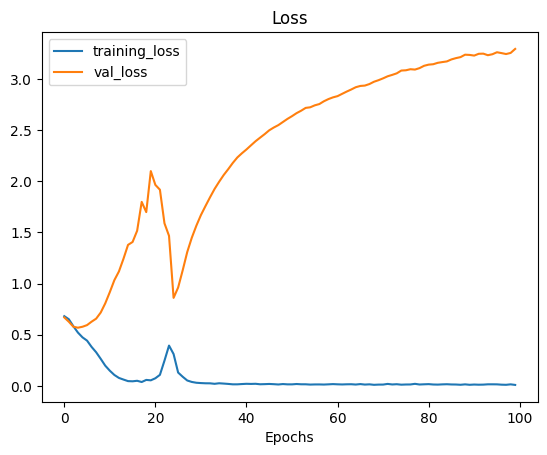

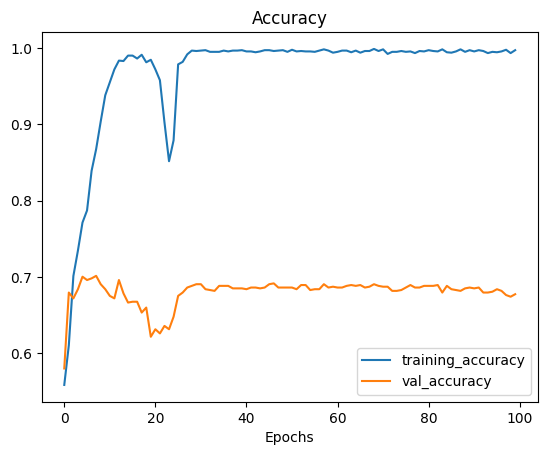

In [34]:
plot_loss_curves(history_model2)


La gráfica muestra la evolución de la pérdida ('loss') durante el entrenamiento de un modelo de aprendizaje profundo a lo largo de 100 épocas. La línea azul representa la pérdida de entrenamiento, que disminuye inicialmente y luego se estabiliza, indicando aprendizaje efectivo. La línea naranja, correspondiente a la pérdida de validación, disminuye al principio pero después aumenta, lo que sugiere sobreajuste, ya que el modelo mejora en los datos de entrenamiento pero pierde capacidad de generalización en datos no vistos.

Se ajusta la arquitectura del modelo para incluir regularización L2 en las capas densas, que penaliza los pesos grandes, y se incrementa el parámetro de Dropout para mitigar el sobreajuste. Además, se compila el modelo con una función de pérdida de entropía cruzada binaria y un optimizador Adam. Por último, se entrena el modelo utilizando Early Stopping, que detiene el entrenamiento cuando no hay mejora en la pérdida de validación después de un número específico de épocas, y se restauran los pesos que lograron el mejor rendimiento en validación.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Ajustar la arquitectura del modelo para incluir regularización L2 y más Dropout
model2 = Sequential()
model2.add(Dense(50, input_shape=(200,), activation='relu', kernel_regularizer=l2(0.001))) # Regularización L2
model2.add(Dense(20, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dense(5, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.3))  # Aumentar el Dropout
model2.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
               metrics=['accuracy'])

# Añadir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con Early Stopping
history_model2 = model2.fit(train_data,
                            validation_data=valid_data,
                            batch_size=128,
                            epochs=num_epochs,
                            callbacks=[early_stopping])  # Añadir Early Stopping aquí


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5716 - loss: 0.7847 - val_accuracy: 0.5799 - val_loss: 0.7306
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5957 - loss: 0.7099 - val_accuracy: 0.6586 - val_loss: 0.6724
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6842 - loss: 0.6458 - val_accuracy: 0.6816 - val_loss: 0.6320
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7254 - loss: 0.5851 - val_accuracy: 0.6893 - val_loss: 0.6235
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7580 - loss: 0.5603 - val_accuracy: 0.6794 - val_loss: 0.6320
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7645 - loss: 0.5428 - val_accuracy: 0.6893 - val_loss: 0.6370
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7801 - loss: 0.5207 - val_accuracy: 0.6904 - val_loss: 0.6517
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7971 - loss: 0.5103 - val_accuracy: 0.6926 - 

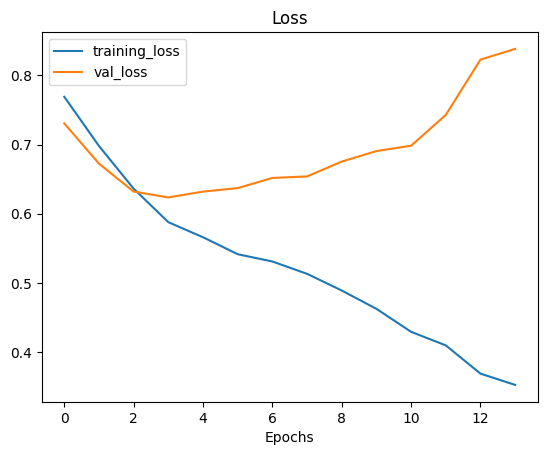

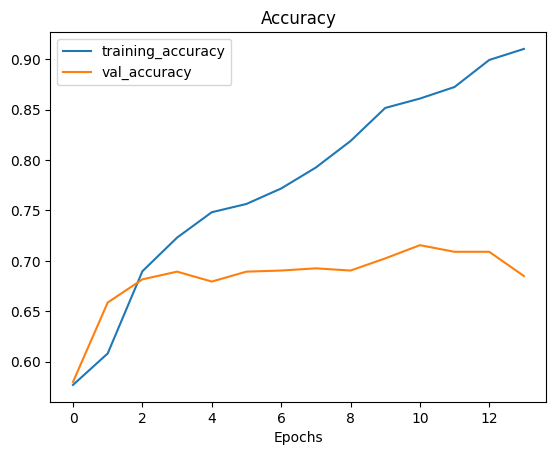

In [36]:
plot_loss_curves(history_model2)

In [37]:
results_deeplearning = calculate_results(labels_test_bin, (model2.predict(test_data) >= 0.5).astype("int32"))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [38]:
results.loc['DeepLearning'] = results_deeplearning

## Módelo 3 |  Enconder LSTM

El `EncoderLSTM` es parte de las arquitecturas seq2seq, utilizadas en PLN y otros dominios, diseñadas para procesar secuencias largas y evitar el desvanecimiento del gradiente. Actúa como codificador, procesando entradas secuenciales (e.g., texto) para generar un vector de contexto que resume la información. Este vector es esencial para el decodificador, que genera la secuencia de salida. Las aplicaciones incluyen traducción automática, resumen de texto, y más.


In [39]:
batch_size = 64
train_data = tf.data.Dataset.from_tensor_slices((X_train,labels_train_bin)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
valid_data = tf.data.Dataset.from_tensor_slices((X_val,  labels_val_bin)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_data  = tf.data.Dataset.from_tensor_slices((X_test, labels_test_bin)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [40]:

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, label: text))

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'i', 'it', 'to', 'a', 'game', 'this',
       'is', 'of', 'you', 'for', 'but', 'that', 'in', 'not', 'have',
       'was'], dtype='<U14')

In [42]:
for example, label in train_data.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I love the series and I love the gameplay of Sons of Liberty when you are actually playing, BUT! there is way too much sitting around in this game. At a couple of points, you sit around for 20 minutes at a time. The clips are good and informative but cmon! This is a game, not the movie of the week!'
 b"Just finished the game yesterday. Everything is remade in beautiful HD, the music has been arranged, new sidequests (this FFX is the international version, so you get a bit more activities) gameplay is awesome, controls are good. Nothing bad to say, really. I played this game back around 2002, and playing it again on the PS3 and also PSVita handheld, is simply pure fun awesomeness and nostalgic. Have a good one guys, don't miss out on this game again and newcomers!"
 b"This is the samething like part one same characters only 3 stages i mean come on this game is not worth it. The customization suck's and the attack's are the same. If you just like this game for it's girl's and 

In [43]:
number = 23
for example, label in train_data.take(1):
  print('texts: ', example.numpy()[number])
  print()
  print("Round-trip: ", " ".join(vocab[  encoder(example)[number].numpy()]))
  print()
  print("encode : ", encoder(example).numpy()[number] )
  print()
  print('labels: ',  label.numpy()[number])

texts:  b"The only bad things the ps2 Madden has is the same ol' mediocre graphics from 04(which I thought has the best graphics on Madden)and the refs call random penalties. Other than that a damn good game with replay value. the 360 Madden is only eye candy."

Round-trip:  the only bad things the ps2 madden has is the same [UNK] mediocre graphics from [UNK] i thought has the best graphics on [UNK] the [UNK] call [UNK] [UNK] other than that a [UNK] good game with replay value the 360 madden is only [UNK] [UNK]                                                   

encode :  [  2  60  98 184   2 264 523  58  10   2 101   1 960  46  55   1   4 180
  58   2  82  46  20   1   2   1 374   1   1  73  72  15   7   1  36   8
  21 456 391   2 178 523  10  60   1   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]

labels:  0


In [44]:
model3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [45]:
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [46]:
history = model3.fit(train_data,
                    validation_data=valid_data,
                    epochs=3,
                    validation_steps=30)

Epoch 1/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.5766 - loss: 0.6924

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 521ms/step - accuracy: 0.5767 - loss: 0.6924 - val_accuracy: 0.5799 - val_loss: 0.6464
Epoch 2/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 432ms/step - accuracy: 0.5767 - loss: 0.6888 - val_accuracy: 0.5799 - val_loss: 0.6421
Epoch 3/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 577ms/step - accuracy: 0.5767 - loss: 0.6838 - val_accuracy: 0.5799 - val_loss: 0.6374


In [47]:
results_EncoderLSTM = calculate_results(labels_test_bin, (model3.predict(test_data) >= 0.5).astype("int32"))

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
results.loc['EncoderLSTM'] = results_EncoderLSTM

#Recopilar modelos

In [49]:
results.to_csv('results_test.csv', sep=';', decimal='.')